## 1. Import Python libraries
<p><img src="https://assets.datacamp.com/production/project_555/img/92_notebook.jpg" alt="honey bee">
<em>A honey bee (Apis).</em></p>
<p>Can a machine identify a bee as a honey bee or a bumble bee? These bees have different <a href="https://www.thesca.org/connect/blog/bumblebees-vs-honeybees-what%E2%80%99s-difference-and-why-does-it-matter">behaviors and appearances</a>, but given the variety of backgrounds, positions, and image resolutions, it can be a challenge for machines to tell them apart.</p>
<p>Being able to identify bee species from images is a task that ultimately would allow researchers to more quickly and effectively collect field data. Pollinating bees have critical roles in both ecology and agriculture, and diseases like <a href="http://news.harvard.edu/gazette/story/2015/07/pesticide-found-in-70-percent-of-massachusetts-honey-samples/">colony collapse disorder</a> threaten these species. Identifying different species of bees in the wild means that we can better understand the prevalence and growth of these important insects.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/20_notebook.jpg" alt="bumble bee">
<em>A bumble bee (Bombus).</em></p>
<p>This notebook walks through building a simple deep learning model that can automatically detect honey bees and bumble bees and then loads a pre-trained model for evaluation.</p>

In [4]:
import pickle
from pathlib import Path
from skimage import io

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# import keras library
import keras

# import Sequential from the keras models module
from keras.models import Sequential

# import Dense, Dropout, Flatten, Conv2D, MaxPooling2D from the keras layers module
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

## 2. Load image labels
<p>Now that we have all of our imports ready, it is time to look at the labels for our data. We will load our <code>labels.csv</code> file into a DataFrame called <code>labels</code>, where the index is the image name (e.g. an index of 1036 refers to an image named 1036.jpg) and the <code>genus</code> column tells us the bee type. <code>genus</code> takes the value of either <code>0.0</code> (Apis or honey bee) or <code>1.0</code> (Bombus or bumble bee).</p>

In [5]:
# load labels.csv from datasets folder using pandas
labels = pd.read_csv("datasets/labels.csv",index_col=0)

# print value counts for genus
print(labels.genus.value_counts())

# assign the genus label values to y
y = labels.genus.values

0.0    827
1.0    827
Name: genus, dtype: int64


## 3. Examine RGB values in an image matrix
<p>Image data can be represented as a matrix. The width of the matrix is the width of the image, the height of the matrix is the height of the image, and the depth of the matrix is the number of channels. Most image formats have three color channels: red, green, and blue.</p>
<p>For each pixel in an image, there is a value for every channel. The combination of the three values corresponds to the color, as per the <a href="https://en.wikipedia.org/wiki/RGB_color_model">RGB color model</a>. Values for each color can range from 0 to 255, so a purely blue pixel would show up as (0, 0, 255).</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/rgb_example.png" width="600"></p>
<p>Let's explore the data for a sample image. </p>

Example image has shape:  (50, 50, 3)
RGB values for the top left pixel are: [127 108  95]


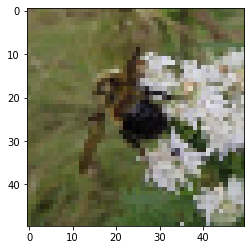

In [6]:
# load an image and explore
example_image = io.imread('datasets/{}.jpg'.format(labels.index[0]))

# show image
plt.imshow(example_image)

# print shape
print('Example image has shape: ', example_image.shape)
                    
# print color channel values for top left pixel
print('RGB values for the top left pixel are:', example_image[0,0,:])

## 4. Importing the image data
<p>Now we will import all images. Once imported, we will stack the resulting arrays into a single matrix and assign it to <code>X</code>.</p>

In [7]:
# create empty list
image_list = list()

for i in labels.index:
    # load image
    img = io.imread('datasets/{}.jpg'.format(i)).astype(np.float64)
        
    # append to list of all images
    image_list.append(img)
    
# convert image list to single array
X = np.array(image_list)

print(X.shape)

(1654, 50, 50, 3)


## 5. Split into train, test, and evaluation sets
<p>Now that we have our big image data matrix, <code>X</code>, as well as our labels, <code>y</code>, we can split our data into train, test, and evaluation sets. To do this, we'll first allocate 20% of the data into our evaluation, or holdout, set. This is data that the model never sees during training and will be used to score our trained model.</p>
<p>We will then split the remaining data, 60/40, into train and test sets just like in supervised machine learning models. We will pass both the train and test sets into the neural network. </p>

In [8]:
# split out evaluation sets (x_eval and y_eval)
x_interim, x_eval, y_interim, y_eval = train_test_split(X,
                                           y,
                                           test_size=0.2,
                                           random_state=52)

# split remaining data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_interim,
                                                   y_interim,
                                                   test_size = 0.4,
                                                   random_state= 52)

# examine number of samples in train, test, and validation sets
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_eval.shape[0], 'eval samples')

x_train shape: (793, 50, 50, 3)
793 train samples
530 test samples
331 eval samples


## 6. Normalize image data
<p>Now we need to normalize our image data. Normalization is a general term that means changing the scale of our data so it is consistent.</p>
<p>In this case, we want each feature to have a similar range so our neural network can learn effectively across all the features. As explained in the <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">sklearn docs</a>, "If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected."</p>
<p>We will scale our data so that it has a mean of 0 and standard deviation of 1. We'll use sklearn's <code>StandardScaler</code> to do the math for us, which entails taking each value, subtracting the mean, and then dividing by the standard deviation. We need to do this for each color channel (i.e. each feature) individually. </p>

In [9]:
# initialize standard scaler
ss = StandardScaler()

def scale_features(train_features, test_features):
    for image in train_features:
        # for each channel, apply standard scaler's fit_transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.fit_transform(image[:, :, channel])
    for image in test_features:
        # for each channel, apply standard scaler's transform method
        for channel in range(image.shape[2]):
            image[:, :, channel] = ss.transform(image[:, :, channel])

# apply scale_features to four sets of features
scale_features(x_interim, x_eval)
scale_features(x_train, x_test)

## 7. Model building (part i)
<p>It's time to start building our deep learning model, a convolutional neural network (CNN). CNNs are a specific kind of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, i.e., that pixels close to each other are often related.</p>
<p>Building a CNN begins with specifying the model type. In our case, we'll use a <a href="https://keras.io/getting-started/sequential-model-guide/">Sequential</a> model, which is a linear stack of layers. We'll then add two convolutional layers. To understand convolutional layers, imagine a flashlight being shown over the top left corner of the image and slowly sliding across all the areas of the image, moving across the image in the same way your eyes move across words on a page. Convolutional layers pass a kernel (a sliding window) over the image and perform element-wise matrix multiplication between the kernel values and the pixel values in the image.</p>

In [10]:
# set model constants
num_classes = 1

# define model as Sequential
model = Sequential()

# first convolutional layer with 32 filters
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 50, 3)))

# add a second 2D convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3,3),activation='relu'))

## 8. Model building (part ii)
<p>Let's continue building our model. So far our model has two convolutional layers. However, those are not the only layers that we need to perform our task. A complete neural network architecture will have a number of other layers that are designed to play a specific role in the overall functioning of the network. Much deep learning research is about how to structure these layers into coherent systems.</p>
<p>We'll add the following layers:</p>
<ul>
<li><a href="https://keras.io/layers/pooling/#maxpooling2d"><code>MaxPooling</code></a>. This passes a (2, 2) moving window over the image and downscales the image by outputting the maximum value within the window.</li>
<li><a href="https://keras.io/layers/convolutional/#conv2d"><code>Conv2D</code></a>. This adds a third convolutional layer since deeper models, i.e. models with more convolutional layers, are better able to learn features from images.</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. This prevents the model from overfitting, i.e. perfectly remembering each image, by randomly setting 25% of the input units to 0 at each update during training.</li>
<li><a href="https://keras.io/layers/core/#flatten"><code>Flatten</code></a>. As its name suggests, this flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.</li>
<li><a href="https://keras.io/layers/core/#dense"><code>Dense</code></a>. Fully connected layer where every input is connected to every output (see image below).</li>
<li><a href="https://keras.io/layers/core/#dropout"><code>Dropout</code></a>. Another dropout layer to safeguard against overfitting, this time with a rate of 50%.</li>
<li><code>Dense</code>. Final layer which calculates the probability the image is either a bumble bee or honey bee.</li>
</ul>
<p>To take a look at how it all stacks up, we'll print the model summary. Notice that our model has a whopping <code>3,669,249</code> paramaters. These are the different weights that the model learns through training and what are used to generate predictions on a new image.</p>
<p><img src="https://assets.datacamp.com/production/project_555/img/mlp_conv.png" alt></p>

In [11]:
# reduce dimensionality through max pooling
model.add(MaxPooling2D(pool_size=(2,2)))

# third convolutional layer with 64 filters
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# add dropout to prevent over fitting
model.add(Dropout(0.25))
# necessary flatten step preceeding dense layer
model.add(Flatten())
# fully connected layer
model.add(Dense(128, activation='relu'))

# add additional dropout to prevent overfitting
model.add(Dropout(0.50))

# prediction layers
model.add(Dense(num_classes, activation='sigmoid', name='preds'))

# show model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 21, 21, 64)        0         
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                        

## 9. Compile and train model
<p>Now that we've specified the model architecture, we will <a href="https://keras.io/models/model/#compile">compile</a> the model for training. For this we need to specify the loss function (what we're trying to minimize), the optimizer (how we want to go about minimizing the loss), and the metric (how we'll judge the performance of the model).</p>
<p>Then, we'll call <a href="https://keras.io/models/model/#fit"><code>.fit</code></a> to begin the trainig the process. </p>
<blockquote>
  <p>"Neural networks are trained iteratively using optimization techniques like gradient descent. After each cycle of training, an error metric is calculated based on the difference between prediction and target…Each neuron’s coefficients (weights) are then adjusted relative to how much they contributed to the total error. This process is repeated iteratively." <a href="https://ml-cheatsheet.readthedocs.io/en/latest/nn_concepts.html">ML Cheatsheet</a></p>
</blockquote>
<p>Since training is computationally intensive, we'll do a 'mock' training to get the feel for it, using just the first 10 images in the train and test sets and training for just 5 epochs. Epochs refer to the number of iterations over the data. Typically, neural networks will train for hundreds if not thousands of epochs.</p>
<p>Take a look at the printout for each epoch and note the loss on the train set (<code>loss</code>), the accuracy on the train set (<code>acc</code>), and loss on the test set (<code>val_loss</code>) and the accuracy on the test set (<code>val_acc</code>). We'll explore this more in a later step.</p>

In [12]:
model.compile(
    # set the loss as binary_crossentropy
    loss=keras.losses.binary_crossentropy,
    # set the optimizer as stochastic gradient descent
    optimizer=keras.optimizers.SGD(learning_rate=0.001),
    # set the metric as accuracy
    metrics=['accuracy']
)

# mock-train the model using the first ten observations of the train and test sets
model.fit(
    x_train[:10, :, :, :],
    y_train[:10],
    epochs=5,
    verbose=1,
    validation_data=(x_test[:10, :, :, :], y_test[:10])
)

Epoch 1/5
1/1 [==============================] - 0s 435ms/step - loss: 0.6473 - accuracy: 0.7000 - val_loss: 0.7114 - val_accuracy: 0.5000
Epoch 2/5
1/1 [==============================] - 0s 46ms/step - loss: 0.6815 - accuracy: 0.5000 - val_loss: 0.7163 - val_accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 44ms/step - loss: 0.6706 - accuracy: 0.6000 - val_loss: 0.7206 - val_accuracy: 0.5000
Epoch 4/5
1/1 [==============================] - 0s 43ms/step - loss: 0.6428 - accuracy: 0.7000 - val_loss: 0.7247 - val_accuracy: 0.5000
Epoch 5/5
1/1 [==============================] - 0s 44ms/step - loss: 0.6884 - accuracy: 0.4000 - val_loss: 0.7299 - val_accuracy: 0.5000


## 10. Load pre-trained model and score
<p>Now we'll load a pre-trained model that has the architecture we specified above and was trained for 200 epochs on the full train and test sets we created above.</p>
<p>Let's use the <a href="https://keras.io/models/model/#evaluate"><code>evaluate</code></a> method to see how well the model did at classifying bumble bees and honey bees for the test and validation sets.  Recall that accuracy is the number of correct predictions divided by the total number of predictions. Given that our classes are balanced, a model that predicts <code>1.0</code> for every image would get an accuracy around <code>0.5</code>.</p>
<p>Note: it may take a few seconds to load the model. Recall that our model has over 3 million parameters (weights), which are what's being loaded.</p>

In [13]:
# load pre-trained model
pretrained_cnn = keras.models.load_model('datasets/pretrained_model.h5')

# evaluate model on test set
score = pretrained_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("")

# evaluate model on holdout set
eval_score = pretrained_cnn.evaluate(x_eval,y_eval)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

Test loss: 0.6719561815261841
Test accuracy: 0.6188679337501526

11/11 [==============================] - 0s 10ms/step - loss: 0.6702 - accuracy: 0.6375
Eval loss: 0.6701621413230896
Eval accuracy: 0.6374622583389282


## 11. Visualize model training history
<p>In addition to scoring the final iteration of the pre-trained model as we just did, we can also see the evolution of scores throughout training thanks to the <a href="https://keras.io/callbacks/#history"><code>History</code></a> object. We'll use the <a href="https://docs.python.org/3/library/pickle.html"><code>pickle</code></a> library to load the model history and then plot it.</p>
<p>Notice how the accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the validation loss as times goes on (a U shape in the plot), we'd suspect that the model was starting to memorize the test set and would not generalize well to new data.</p>

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


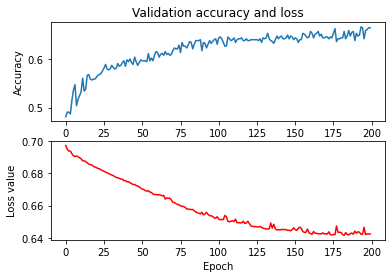

In [14]:
# load history
with open('datasets/model_history.pkl', 'rb') as f:
    pretrained_cnn_history = pickle.load(f)

# print keys for pretrained_cnn_history dict
print(pretrained_cnn_history.keys())

fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(pretrained_cnn_history['val_acc'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(pretrained_cnn_history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');

## 12. Generate predictions
<p>Previously, we calculated an overall score for our pre-trained model on the validation set. To end this notebook, let's access probabilities and class predictions for individual images using the <code>.predict()</code> method and <code>np.round()</code>.</p>
<p>We now have a deep learning model that can be used to identify honey bees and bumble bees in images! The next step is to explore transfer learning, which harnesses the prediction power of models that have been trained on far more images than the mere 1600 in our dataset.</p>

In [15]:
# predicted probabilities for x_eval
y_proba = pretrained_cnn.predict(x_eval)

print("First five probabilities:")
print(y_proba[:4])
print("")

# predicted classes for x_eval
y_pred = np.round(y_proba).astype('int')

print("First five class predictions:")
print(y_pred[:5])
print("")

11/11 [==============================] - 0s 10ms/step
First five probabilities:
[[0.5104395 ]
 [0.5508864 ]
 [0.63334477]
 [0.18111487]]

First five class predictions:
[[1]
 [1]
 [1]
 [0]
 [0]]



# End of Datacamp Project
# -----------------------------------------------------
# Start of Personal Additions

## 1. Introduction 
In the data camp project, we conducted binary classification. In this extension project, we will attempt to extend this project to multicategorical classification. Primary, we will be interested in predicting the accuracy among three groups: 'Bees', 'Wasps', and 'Other Insects'.

The very first thing we will do is to revert the original 50 by 50 pixel images to their original dimensions. This will take a little bit of searching for the data but also, we will update our original 1654 images of bees to 4966. Furthermore, we will no longer divide them by Genus as we are now only concerned with whether they are a bee, wasp, or neither. 

## 2. Looking at the reverted image 
Let's first look at what a reverted image looks like from the original dataset. The original image should have 200 x 200 pixels

Reduced image has shape:  (50, 50, 3)
Original image has shape:  (200, 200, 3)


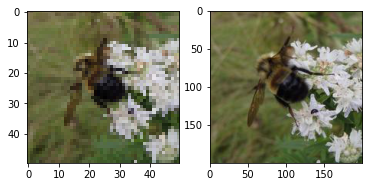

In [16]:
f, axarr = plt.subplots(1,2)

#reduced image
reduced_image = io.imread('datasets/520.jpg')

#show reduced image 
axarr[0].imshow(reduced_image)

#original image
original_image = io.imread('insects/bees/520.jpg')

#show reduced image
axarr[1].imshow(original_image)

#reduced image vs original image
print('Reduced image has shape: ', reduced_image.shape)
print('Original image has shape: ', original_image.shape)

As you can see, the original image contains a lot more detail and if there is enough computational power, then this image should supply more accuracy and lower loss since it contains more information from additional pixels.

## 3. Looking at other images 
Let's take a look at other images in our dataset that we are going to train with. Our primary goal is to hopefully do a good job differentiating bees from wasps and from other insects.

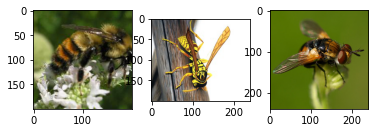

In [17]:
f, axarr = plt.subplots(1,3)

#image of a bee
bee_image = io.imread('insects/bees/1.jpg')
axarr[0].imshow(bee_image)

#image of a wasp
wasp_image = io.imread('insects/wasps/wasp1.jpg')
axarr[1].imshow(wasp_image)

#image of other insect
other_image = io.imread('insects/other/fly1.jpg')
axarr[2].imshow(other_image)

You will notice that the resolution of these three images may not be the same. This will be something that we will tackle later on in this project to make them all uniform.

## 4. Preprocessing our data
Extending from the datacamp project from above, let's also attemp to build a very basic multiclass categorical deep learning classifier using keras and tensorflow. This will be the first basic model that we attempt and therefore will not be very accurate as we will see. This first model has many problems which I will discuss in detail as we increase the complexity of this extension.

#### a). Specifying image size and batch size
We start off with importing tensorflow and specifying how big our image will be and our batch size.

In [102]:
#Here we import tensorflow as tf
import tensorflow as tf

#setting up base directory
#this will inform keras where each folder for our classifier is
base_dir = r"C:\Users\Jason\Desktop\project\insects"

#we wish to specify image size and batch size
#reducing image size will make computation much easier
#reducing batch size will help us reduce memory load
IMAGE_SIZE=224
BATCH_SIZE=64

#### b). Creating test and training datasets
Previously, we created testing and datasets from using the train_test_split(). But we need a special sort of method to split the image data into categorical datasets. In this step, we specify the split for our training and testing dataset. 

For our training dataset, we rescale our image data. We scale by a factor of 1/255 to account for RGB values that go from 0-255 which are too high for our model to process. 

There are also other arguments we added to prevent overfitting.
- ```zoom_range = 0.2``` which will zoom 1.2 times on a random part of the image to prevent overfitting. 
- ```horizontal_flip = true``` randomly flip horizontally
- ```shear_range = 0.2 ``` randomly distorts an image along the y-axis to account for how humans see things from different angles

Finally, we set the ```validation_split = 0.1``` to set some images aside for evaluation of our model.

For our testing dataset, only need to specify the split since we do not need to distort the images for randomness since it is there to validate our results.

In [103]:
#pre-processing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    validation_split = 0.1
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split = 0.1
)

#### c). Specifying classes

Now we connect it with our file directory to get the classes from each specific folder. In the code below, we classify our data and specify whether it is reserved for training or validation.

In [104]:
#connecting it with our file directory

#training data
train_datagen = train_datagen.flow_from_directory(
    #base_dir locates the folders that separate image classes
    base_dir,
    #target size is what size of the image are we looking for
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    #how many batches we wish to include before resetting parameters
    batch_size = BATCH_SIZE,
    #classes that we have
    classes = ["bees","wasps","other"],
    #what type of data type
    class_mode = 'categorical',
    #training or validation
    subset='training'
)

#testing data
test_datagen = test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    classes = ["bees","wasps","other"],
    class_mode = 'categorical',
    subset = 'validation'
)

Found 11110 images belonging to 3 classes.
Found 1233 images belonging to 3 classes.


As specified by the output, we see that we have three classes with a total of 12343 images detected for three classes.
1233 of these images are reserved for validation. 

## 5. Building a basic model
Now that we have proprocessed our data, let's build a basic model. We will build a simple model that is not the most effective but it will give us an idea of how our model performs with the most basic layers.

#### a). Defining Model type and first layer
Just like in the binary classfication case, we wish to use a sequential model from keras. Furthermore, we have a very similar Conv2D layer except now that our input is (224,224,3) that matches our resized images. 

We added two more functions to decrease the loss of shrinkage from our images:

```padding = same```

```strides = 2```

In [105]:
#Here we use the sequential model just as we did above
cnn=Sequential()

#we add one convolution layer with filters = 64
cnn.add(Conv2D(filters=64,
                        #padding increases height and out
                        #it removes undesirable shrinkage of the output
                        padding='same',
                        #stride performs a similar row to padding
                        strides=2,
                        kernel_size=3,
                        activation='relu',
                        input_shape=(224,224,3)
                       ))

#### b). Adding additional layers
Just like in the binary case, we want to add additional layers to make our model more complex so that it can better predict results. Here, we add one more covlutional layer with two additional dropout layers and maxpooling layers. Our output is softmax since we are doing multiclassification.

In [106]:
#cnn dropout layer
model.add(Dropout(0.25))

#maxpooling layer
cnn.add(MaxPooling2D(pool_size=2,strides=2))

#another convolutional layer
cnn.add(Conv2D(filters=64,
                        padding='same',
                        strides=2,
                        kernel_size=3,
                        activation='relu'
                       ))

#cnn dropout layer
model.add(Dropout(0.10))

#maxpooling layer
cnn.add(MaxPooling2D(pool_size=2,strides=2))

#flatten layer
cnn.add(Flatten())

#dense layer
cnn.add(Dense(3,activation='softmax'))

#### c) Compiling the model
We compile our model and the summary results below. We can see that we end up with a total of 76,355 parameters which is actually less than the binary classficiation that we performed above in datacamp.

In [107]:
#compiling our simple model
cnn.compile(
    optimizer = tf.keras.optimizers.Adam(),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 12544)             0         
                                                                 
 dense_15 (Dense)            (None, 3)               

## 6. Fitting our model
Below we train our model with 10 epochs. We see that already with only 10 epochs, training time is around 15 minutes. Thus, if we wish to train with higher epochs, we will have to carefully finetune our model parameters so computational power is sufficient to finish fitting the model. We want to add complexity very carefully for subsequent improvements of our model for our next attempt at a better model.

In [108]:
cnn.fit(train_datagen,
        epochs=10,
        validation_data = test_datagen)

Epoch 1/10
174/174 [==============================] - 97s 553ms/step - loss: 0.7466 - accuracy: 0.6893 - val_loss: 0.7998 - val_accuracy: 0.6788
Epoch 2/10
174/174 [==============================] - 95s 545ms/step - loss: 0.5565 - accuracy: 0.7833 - val_loss: 0.6242 - val_accuracy: 0.7510
Epoch 3/10
174/174 [==============================] - 95s 543ms/step - loss: 0.4965 - accuracy: 0.8101 - val_loss: 0.5466 - val_accuracy: 0.7835
Epoch 4/10
174/174 [==============================] - 95s 546ms/step - loss: 0.4531 - accuracy: 0.8327 - val_loss: 0.4879 - val_accuracy: 0.8167
Epoch 5/10
174/174 [==============================] - 95s 548ms/step - loss: 0.4220 - accuracy: 0.8420 - val_loss: 0.5225 - val_accuracy: 0.7940
Epoch 6/10
174/174 [==============================] - 96s 549ms/step - loss: 0.4091 - accuracy: 0.8518 - val_loss: 0.4856 - val_accuracy: 0.8232
Epoch 7/10
174/174 [==============================] - 97s 555ms/step - loss: 0.3790 - accuracy: 0.8604 - val_loss: 0.4641 - val_ac

Here we got impressive validation accuracy and test accuracy. Thus the model should be quite good or it is overfitting. We should run some validation of our own to confirm such suspicions

Furthermore, from above, we can see that only 174 images are being used for validation. This is quite small. For our next batch, we should separate more of our images into a validation dataset. Thus, this model is not the most realiable in terms of actual representation of how good our model will perform on larger real life datasets.

#### a). Saving the model
We are saving a sample of our model so that we do not have to retrain it every time.

In [118]:
#save file from first time doing the model
cnn.save('sample_model2.h5')
cnn = keras.models.load_model('sample_model2.h5')

#### b) Predicting results
Let's load a simple image of a wasp and see what this model predicts.

{'bees': 0, 'wasps': 1, 'other': 2}
predicted output:  1


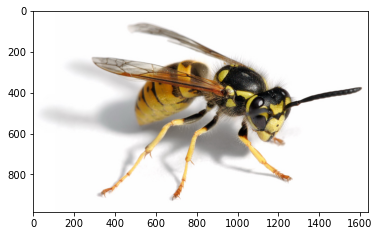

In [112]:
#displaying the image
image = io.imread("wasp.jpg")
plt.imshow(image)

#reading the image in 
img_pred = tf.keras.utils.load_img("wasp.jpg")

#resizing the image
img_pred = img_pred.resize((224,224))

#transforming image to array so we can feed it into the model
img_pred = tf.keras.utils.img_to_array(img_pred)

#we use expand_dims to stack our matrix together
img_pred = np.expand_dims(img_pred,axis=0)

#we predict the outcome
pred = cnn(img_pred)

#we print both the result as well as the class index to help identify our results
print(test_datagen.class_indices)
print("predicted output: ", np.argmax(pred))

Here we see that it correctly identified the image as a wasp. However, if we run the code below, we see that it inaccurately identifies a bee as a wasp.

#### b) Predicting results 2
Second attempt at predicting with a bee.

{'bees': 0, 'wasps': 1, 'other': 2}
predicted output:  1


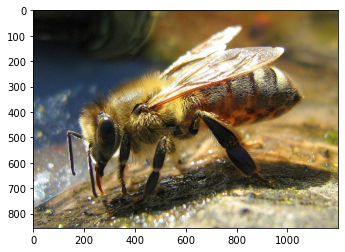

In [113]:
#displaying the image
image = io.imread("bee.jpg")
plt.imshow(image)

#reading the image in 
img_pred = tf.keras.utils.load_img("bee.jpg")

#resizing the image
img_pred = img_pred.resize((224,224))

#transforming image to array so we can feed it into the model
img_pred = tf.keras.utils.img_to_array(img_pred)

#we use expand_dims to stack our matrix together
img_pred = np.expand_dims(img_pred,axis=0)

#we predict the outcome
pred = cnn(img_pred)

#we print both the result as well as the class index to help identify our results
print(test_datagen.class_indices)
print("predicted output: ", np.argmax(pred))

Here it attempted the prediction but still classified a bee as a wasp. Let us manually attempt to verify accuracy through loops to see if our model is actually performing as well as it think it is.

#### b). Manually verifying accuracy (bees image set)
From our epochs, we see that our model is suppose to be somewhat accurate. However, what if we manually verify how accurate our model is? The code below loops through all images of the bees image dataset. It records how many times we actually correctly identify a bee vs incorrectly identifying a bee. We show the results below. 

In [114]:
import os
from os import listdir

#specify folder directory
folder_dir = "insects/bees"

#counter variable that tracks our model's prediction count for each class in bees image set
track = np.array([0,0,0])

#loop that goes through the folder_dir
for images in os.listdir(folder_dir):
    #only run if the file ends with ".jpg"
    if (images.endswith(".jpg")):
        #loads every image
        img_pred = tf.keras.utils.load_img("insects/bees/{}".format(images))
        #resize
        img_pred = img_pred.resize((224,224))
        #transform to array
        img_pred = tf.keras.utils.img_to_array(img_pred)
        #stack array
        img_pred = np.expand_dims(img_pred,axis=0)
        #predict result
        pred = cnn(img_pred)
        
        #increment for each prediction
        if np.argmax(pred) == 0:
            track[0] = track[0] + 1
        elif np.argmax(pred) == 1:
            track[1] = track[1] + 1
        elif np.argmax(pred) == 2: 
            track[2] = track[2] + 1

#classes
print("classes", test_datagen.class_indices)
#number of predictions for each            
print("prediction for each class: ",track)
#total predictions
print("total predictions: ",sum(track))
#prediction accuracy
print("prediction accuracy: ",track[0]/sum(track))

classes {'bees': 0, 'wasps': 1, 'other': 2}
prediction for each class:  [2061 2280  620]
total predictions:  4961
prediction accuracy:  0.4154404353960895


We see our model is not peforming as well as the model think it is. Thus, it may be overfitting. This may be due to several reasons. One, it could be the small validation set of images and it may also be because we are not training the model for long enough. Regardless, it is not bad for our first attempt at the model.

#### c). Manually verifying accuracy (wasp)

Let's do the same with the wasp data set to verify accuracy.

In [115]:
#changing folder_dir
folder_dir = "insects/wasps"

#counter variable that tracks our model's prediction count for each class in bees image set
track = np.array([0,0,0])


#loop that goes through the folder_dir
for images in os.listdir(folder_dir):
    #only run if the file ends with ".jpg"
    if (images.endswith(".jpg")):
        #loads every image
        img_pred = tf.keras.utils.load_img("insects/wasps/{}".format(images))
        #resize
        img_pred = img_pred.resize((224,224))
        #transform to array
        img_pred = tf.keras.utils.img_to_array(img_pred)
        #stack array
        img_pred = np.expand_dims(img_pred,axis=0)
        #predict result
        pred = cnn(img_pred)
        
        #increment for each prediction
        if np.argmax(pred) == 0:
            track[0] = track[0] + 1
        elif np.argmax(pred) == 1:
            track[1] = track[1] + 1
        elif np.argmax(pred) == 2: 
            track[2] = track[2] + 1

#classes
print("classes", test_datagen.class_indices)
#number of predictions for each            
print("prediction for each class: ",track)
#total predictions
print("total predictions: ",sum(track))
#prediction accuracy
print("prediction accuracy: ",track[1]/sum(track))

classes {'bees': 0, 'wasps': 1, 'other': 2}
prediction for each class:  [ 283 4196  463]
total predictions:  4942
prediction accuracy:  0.849048968029138


We see that for wasps, it got a much higher prediction accuracy. Thus, it is outperforming bees.

#### d). Manually verifying accuracy (other)

Finally, let's perform the same on the 'Other Insects' category

In [117]:
import os
from os import listdir

#specify folder directory
folder_dir = "insects/other"

#counter variable that tracks our model's prediction count for each class in bees image set
track = np.array([0,0,0])

#loop that goes through the folder_dir
for images in os.listdir(folder_dir):
    #only run if the file ends with ".jpg"
    if (images.endswith(".jpg")):
        #loads every image
        img_pred = tf.keras.utils.load_img("insects/other/{}".format(images))
        #resize
        img_pred = img_pred.resize((224,224))
        #transform to array
        img_pred = tf.keras.utils.img_to_array(img_pred)
        #stack array
        img_pred = np.expand_dims(img_pred,axis=0)
        #predict result
        pred = cnn(img_pred)
        
        #increment for each prediction
        if np.argmax(pred) == 0:
            track[0] = track[0] + 1
        elif np.argmax(pred) == 1:
            track[1] = track[1] + 1
        elif np.argmax(pred) == 2: 
            track[2] = track[2] + 1

#classes
print("classes", test_datagen.class_indices)
#number of predictions for each            
print("prediction for each class: ",track)
#total predictions
print("total predictions: ",sum(track))
#prediction accuracy
print("prediction accuracy: ",track[2]/sum(track))

classes {'bees': 0, 'wasps': 1, 'other': 2}
prediction for each class:  [  12  917 1510]
total predictions:  2439
prediction accuracy:  0.6191061910619107


The model is also quite good at identifying other insects. Thus, currently, it is poor at identifying and recgonizing bees. Regardless, it is a good sign that two of our categories classification scored positvely with good accuracy. With all of this verified, our initial model proves to be on a good start. Let's build a real model by increasing our model complexity and see if that performs as well or worse than our current model!

## 7. Extending our original model

Now we will began our final process of creating a complex and robust model. Let us do the same as above but now with extra layers and additional epochs. We will examine if this model performs just as well as the original if not better than the original.

#### a). Preprocessing our data

In this extended model, `image_size` stays the same but `batch_size` gets reduced to 1. Reducing batch size allows for greater variation and reduce large updates in our gradient descent. Generally, a smaller batch leads to a model that makes updates that are around the same size. 

Furthermore, we decrease both `sheer_range = 0.15` and `zoom_range = 0.15`. This is to allow for greater capture of the original image to hopefully let the model learn more effectively the original dataset. Finally, we improved  the `validation_split = 0.20` for a larger sample that will more accurately verify our training results.

In [119]:
#directory remains the same
base_dir = r"C:\Users\Jason\Desktop\project\insects"

#image size stays the same
IMAGE_SIZE=224

#batch size is decreased to allow for greater variation and more accuracy
BATCH_SIZE=1

#pre-processing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    #decreasing shear_range
    shear_range=0.15,
    #decrasing zoom_range
    zoom_range = 0.15,
    horizontal_flip=True,
    #increasing validation data
    validation_split = 0.20
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    #increasing validation data
    validation_split = 0.20
)

#### b). Specifying classes
The code in this section remain the same as our preliminary model. The only change is the output in which we now see that we have 2467 images for our test data set and 9876 images for our training dataset.

In [120]:
#everything from this section stays the same

#training data
train_datagen = train_datagen.flow_from_directory(
    #base_dir locates the folders that separate image classes
    base_dir,
    #target size is what size of the image are we looking for
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    #how many batches we wish to include before resetting parameters
    batch_size = BATCH_SIZE,
    #classes that we have
    classes = ["bees","wasps","other"],
    #what type of data type
    class_mode = 'categorical',
    #training or validation
    subset='training'
)

#testing data
test_datagen = test_datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    classes = ["bees","wasps","other"],
    class_mode = 'categorical',
    subset = 'validation'
)

Found 9876 images belonging to 3 classes.
Found 2467 images belonging to 3 classes.


#### c). Defining Model type and first layer
The first layer of our new complex model does not change. It remains the same as our original model.

In [121]:
#Here we use the sequential model just as we did above
teras=Sequential()

#we add one convolution layer with filters = 64
teras.add(Conv2D(filters=64,
                        #padding increases height and out
                        #it removes undesirable shrinkage of the output
                        padding='same',
                        #stride performs a similar row to padding
                        strides=2,
                        kernel_size=3,
                        activation='relu',
                        input_shape=(224,224,3)
                       ))

#### d). Adding Additional Layers
This below is where the biggest change occurs. In this model, we added 5 more hidden layers to increase model complexity so that our neural network may better capture features of our images. Furthermore, more dropout layers are added to decrease the possibility of overfitting. In total, the new model adds the following layers:

1. `Conv2D Layer: 128 filters`

2. `Conv2D layer: 32 filters`

3. `Dropout layer: 0.5`

4. `Dense layer: 128`

5. `Dropout layer: 0.6`

This does not account for the added maxpooling layers as well as alterations to previous Dropout layers which is commented on in the code chunk below. In the next section, we take a look at the model summary to see how many new parameters are added to our newly created model.

In [122]:
#original
#reduce drop out layer
teras.add(Dropout(0.20))

#original
#maxpooling layer
teras.add(MaxPooling2D(pool_size=2,strides=2))

#original
#another convolutional layer
#increased filters
teras.add(Conv2D(filters=64,
                        padding='same',
                        strides=2,
                        kernel_size=3,
                        activation='relu'
                       ))


#maxpooling layer
teras.add(MaxPooling2D(pool_size=2,strides=2))

#cnn dropout layer
teras.add(Dropout(0.2))

#new conv layer
teras.add(Conv2D(filters=128,
                        padding='same',
                        strides=2,
                        kernel_size=3,
                        activation='relu'
                       ))

#maxpooling layer
teras.add(MaxPooling2D(pool_size=2,strides=2))

#new conv layer
teras.add(Conv2D(filters=32,
               padding='same',
               strides=2,
               kernel_size=3,
               activation='relu'
                       ))

#new dropout layer
teras.add(Dropout(0.3))

#new dense layer
# fully connected layer
teras.add(Dense(128, activation='relu'))

#new dropout layer
# add additional dropout to prevent overfitting
teras.add(Dropout(0.60))

#original
#flatten layer
teras.add(Flatten())

#original
#dense layer
teras.add(Dense(3,activation='softmax'))

#### e) Compiling our new model
Here, we see the summary output of our new model. A few changes in this section involve the optimizer which we changed from adam to `SGD` which stands for stochastic gradient descent. This optimizer performs better with CNN networks compared to the adam optimizer. We still set `learning_rate=0.001` and `metrics=['accuracy']`

In [123]:
#compiling our simple model
teras.compile(
    #changed our optimizer from adam to SGD which functions betterw with cnn
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

teras.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 112, 112, 64)      1792      
                                                                 
 dropout_40 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 dropout_41 (Dropout)        (None, 14, 14, 64)      

Here, we see that our new model has 155,235 parameters. Our previous model had 76,335 parameters. This model doubles in available tunings in parameters and therefore should better capture features that were hidden from our simple model from before. However, note that the drawback of a more complex model is the significantly more exhaustive computational power as well as time invested in training the model. Thus, unlike the previous model, it is recommended that we set a early stop point in which the model stops training if it gets too inefficient or start to overfit.

#### f).  Adding early stopping to our model
Since our model is now a lot more complex and require much longer to train, it is best to implement EarlyStopping to halt the model if results start to falter due to overtraining or just a lack of substantital progress. 

Here, we set `monitor='val_loss'` which indicates the metric in which we observe. In this case, we are interested in minimizing the validation loss of our model. 

Furthermore `min_delta = 0.003` specifies the minimum acceptable decrease of our validation loss given 10 epochs. 
The 10 epochs is specified through the argument `patience = 10`. 

Finally, the only other important argument is `restore_best_weights = true` which simply save the model on the epoch in which our validation loss is lowest. This is especially useful if one is training on a large epoch.

In [ ]:
#added early stopping and restore_best_weights to get epoch with best model
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,
    patience=10,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

#### g). training our model
Below we train our new model. Here we specify callbacks to be our early stopping variable mentioned above and we set our `epochs = 150`. In total this portion of the model took 4 hours to train and it stopped at epoch 48. Thus, the model failed to improve its minimum validation by 0.003 since training at epoch 38. Below are the run results of the training. 

In [124]:
#increased epochs to 150
toastymodel = teras.fit(
    train_datagen,
    epochs=150,
    validation_data = test_datagen,
    callbacks = [early_stopping_monitor]
)

Epoch 1/150
9876/9876 [==============================] - 203s 21ms/step - loss: 1.0461 - accuracy: 0.4150 - val_loss: 1.0278 - val_accuracy: 0.5091
Epoch 2/150
9876/9876 [==============================] - 187s 19ms/step - loss: 0.9341 - accuracy: 0.5541 - val_loss: 0.8966 - val_accuracy: 0.6036
Epoch 3/150
9876/9876 [==============================] - 186s 19ms/step - loss: 0.7781 - accuracy: 0.6781 - val_loss: 0.8750 - val_accuracy: 0.6141
Epoch 4/150
9876/9876 [==============================] - 186s 19ms/step - loss: 0.7150 - accuracy: 0.7186 - val_loss: 0.8297 - val_accuracy: 0.6315
Epoch 5/150
9876/9876 [==============================] - 185s 19ms/step - loss: 0.6730 - accuracy: 0.7382 - val_loss: 0.7784 - val_accuracy: 0.6668
Epoch 6/150
9876/9876 [==============================] - 185s 19ms/step - loss: 0.6370 - accuracy: 0.7520 - val_loss: 0.7702 - val_accuracy: 0.6725
Epoch 7/150
9876/9876 [==============================] - 184s 19ms/step - loss: 0.6109 - accuracy: 0.7619 - val_

#### h). Visualizing our results
Below is a visualization of our validation accuracy and loss. As seen from below, it appears that validation accuracy and loss did not actually reach its global minimia. This is due to the still very frequent fluctuations that often occur in both the validation accuracy and loss graph. From the graphs below, it appears that the model still has possibilities of improvement in accuracy as well decrease in loss. Thus, it may be a good idea to continue training and increase patience of our early stopping monitor.

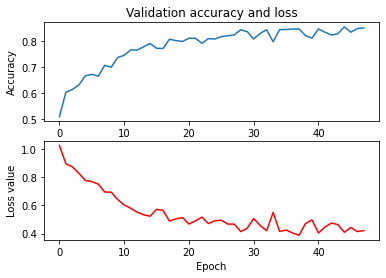

In [148]:
#visualizing the loss
fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(toastymodel.history['val_accuracy'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');

#### i). Continuing model training
Thankfully, keras does not reset the model after previous training is complete. Thus, we can just call fit() again to continue training on our previous model. Here the only difference is that `patience` for early stopping is increased from 10 to 20. Furhermore, the model does not train for 150 more epochs but instead for a maximum of 42. This portion of training maxed out the memory as well as the CPU in my current hardware. As the model gets increasingly more finetuned, training times also slowed. This portion of the training took an additional 3 hours. In total, the complete model took 7 hours to train. 

In [145]:
#training additional models just to be same

#added eraly stopping and restore_best_weights to get epoch with best model
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

#increased epochs to 150
toastymodel2 = teras.fit(
    train_datagen,
    epochs=42,
    validation_data = test_datagen,
    callbacks = [early_stopping_monitor]
)

Epoch 1/42
9876/9876 [==============================] - 288s 29ms/step - loss: 0.2376 - accuracy: 0.9132 - val_loss: 0.4736 - val_accuracy: 0.8245
Epoch 2/42
9876/9876 [==============================] - 284s 29ms/step - loss: 0.2437 - accuracy: 0.9110 - val_loss: 0.4118 - val_accuracy: 0.8504
Epoch 3/42
9876/9876 [==============================] - 286s 29ms/step - loss: 0.2351 - accuracy: 0.9120 - val_loss: 0.5454 - val_accuracy: 0.7977
Epoch 4/42
9876/9876 [==============================] - 289s 29ms/step - loss: 0.2269 - accuracy: 0.9194 - val_loss: 0.4099 - val_accuracy: 0.8573
Epoch 5/42
9876/9876 [==============================] - 290s 29ms/step - loss: 0.2255 - accuracy: 0.9186 - val_loss: 0.4288 - val_accuracy: 0.8476
Epoch 6/42
9876/9876 [==============================] - 292s 30ms/step - loss: 0.2260 - accuracy: 0.9151 - val_loss: 0.5166 - val_accuracy: 0.8079
Epoch 7/42
9876/9876 [==============================] - 289s 29ms/step - loss: 0.2223 - accuracy: 0.9171 - val_loss: 0

#### j). Saving our model and model history
Here, we save our model as well as the model history for future use.

In [149]:
#saving the extended model
teras.save('insect_model2.h5')

#saving the history of the model
with open('insectHistoryDict2.h5','wb') as file_pi:
    pickle.dump(toastymodel2.history, file_pi)
    
#loading it in as history
with open('insectHistoryDict2.h5', "rb") as file_pi:
    history = pickle.load(file_pi)

#### k). Visualizing additional training results

Below, we see the training results for our model training on 37 additional epochs. As visualized by the graph below, it can be seen that the model begans to have a hard time improving both accuracy and loss compared to the start of its training. Looking at the graph below, we stop model training and test its accuracy on real datasets. 

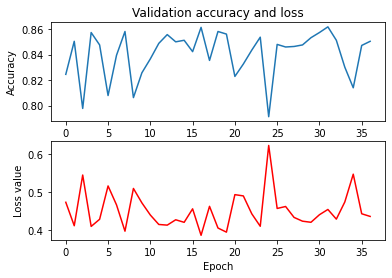

In [150]:
#visualizing the loss for our second validation
fig = plt.figure(1)
plt.subplot(211)
# plot the validation accuracy
plt.plot(toastymodel2.history['val_accuracy'])
plt.title('Validation accuracy and loss')
plt.ylabel('Accuracy')
plt.subplot(212)
# plot the validation loss
plt.plot(toastymodel2.history['val_loss'], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss value');

#### l). Model Evaluation (Wasp)
Here we run a simple prediction on a picture of a wasp.

{'bees': 0, 'wasps': 1, 'other': 2}
predicted output:  1


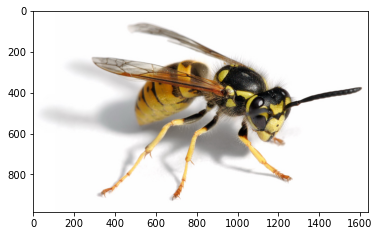

In [151]:
#displaying the image
image = io.imread("wasp.jpg")
plt.imshow(image)

#reading the image in 
img_pred = tf.keras.utils.load_img("wasp.jpg")

#resizing the image
img_pred = img_pred.resize((224,224))

#transforming image to array so we can feed it into the model
img_pred = tf.keras.utils.img_to_array(img_pred)

#we use expand_dims to stack our matrix together
img_pred = np.expand_dims(img_pred,axis=0)

#we predict the outcome
pred = teras(img_pred)

#we print both the result as well as the class index to help identify our results
print(test_datagen.class_indices)
print("predicted output: ", np.argmax(pred))

As seen from the above output, our model successfully managed to predict that it is a wasp!

#### m). Model Evaluation (Bee)
Here we run a simple prediction on a picture of a bee.

{'bees': 0, 'wasps': 1, 'other': 2}
predicted output:  0


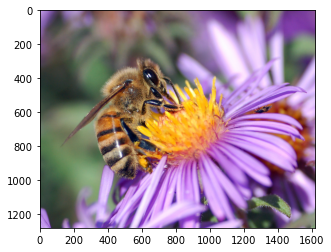

In [152]:
#displaying the image
image = io.imread("bee2.jpg")
plt.imshow(image)

#reading the image in 
img_pred = tf.keras.utils.load_img("bee2.jpg")

#resizing the image
img_pred = img_pred.resize((224,224))

#transforming image to array so we can feed it into the model
img_pred = tf.keras.utils.img_to_array(img_pred)

#we use expand_dims to stack our matrix together
img_pred = np.expand_dims(img_pred,axis=0)

#we predict the outcome
pred = teras(img_pred)

#we print both the result as well as the class index to help identify our results
print(test_datagen.class_indices)
print("predicted output: ", np.argmax(pred))

Again, our model is able to accurately deduce that the insect on the flower is a bee!

#### n). Model Evaluation (Bee Dataset)
Here, we run our model through the entire image dataset of bees. Just as before, we check for the accuracy to see how well our model is performing on real datasets.

In [153]:
#specify folder directory
folder_dir = "insects/bees"

#counter variable that tracks our model's prediction count for each class in bees image set
track = np.array([0,0,0])

#loop that goes through the folder_dir
for images in os.listdir(folder_dir):
    #only run if the file ends with ".jpg"
    if (images.endswith(".jpg")):
        #loads every image
        img_pred = tf.keras.utils.load_img("insects/bees/{}".format(images))
        #resize
        img_pred = img_pred.resize((224,224))
        #transform to array
        img_pred = tf.keras.utils.img_to_array(img_pred)
        #stack array
        img_pred = np.expand_dims(img_pred,axis=0)
        #predict result
        pred = teras(img_pred)
        
        #increment for each prediction
        if np.argmax(pred) == 0:
            track[0] = track[0] + 1
        elif np.argmax(pred) == 1:
            track[1] = track[1] + 1
        elif np.argmax(pred) == 2: 
            track[2] = track[2] + 1

#classes
print("classes", test_datagen.class_indices)
#number of predictions for each            
print("prediction for each class: ",track)
#total predictions
print("total predictions: ",sum(track))
#prediction accuracy
print("prediction accuracy: ",track[0]/sum(track))

classes {'bees': 0, 'wasps': 1, 'other': 2}
prediction for each class:  [4593  209  159]
total predictions:  4961
prediction accuracy:  0.9258214069744003


The prediction accuracy is very high! Thus our model is good at predicting a bee apart from other insects.

#### o). Model Evaluation (Wasp Dataset)
We do the same with the wasp image dataset.

In [154]:
#specify folder directory
folder_dir = "insects/wasps"

#counter variable that tracks our model's prediction count for each class in bees image set
track = np.array([0,0,0])

#loop that goes through the folder_dir
for images in os.listdir(folder_dir):
    #only run if the file ends with ".jpg"
    if (images.endswith(".jpg")):
        #loads every image
        img_pred = tf.keras.utils.load_img("insects/wasps/{}".format(images))
        #resize
        img_pred = img_pred.resize((224,224))
        #transform to array
        img_pred = tf.keras.utils.img_to_array(img_pred)
        #stack array
        img_pred = np.expand_dims(img_pred,axis=0)
        #predict result
        pred = teras(img_pred)
        
        #increment for each prediction
        if np.argmax(pred) == 0:
            track[0] = track[0] + 1
        elif np.argmax(pred) == 1:
            track[1] = track[1] + 1
        elif np.argmax(pred) == 2: 
            track[2] = track[2] + 1

#classes
print("classes", test_datagen.class_indices)
#number of predictions for each            
print("prediction for each class: ",track)
#total predictions
print("total predictions: ",sum(track))
#prediction accuracy
print("prediction accuracy: ",track[1]/sum(track))

classes {'bees': 0, 'wasps': 1, 'other': 2}
prediction for each class:  [1196 2292 1454]
total predictions:  4942
prediction accuracy:  0.46377984621610685


We see that our model does not perform as well on the wasp image data. Instead, it performs even worse than our intial model which is a concern. This may be due to several factors - one of which may be that this model is overtuned to identify bees but is not very good at identifying wasp or other insects. This may also be due to the reduction of our training data size since we added more images to our validation data. 

#### p). Model Evaluation (Other Insects Dataset)
Finally, we perform the same with the category of other insects.

In [156]:
#specify folder directory
folder_dir = "insects/other"

#counter variable that tracks our model's prediction count for each class in bees image set
track = np.array([0,0,0])

#loop that goes through the folder_dir
for images in os.listdir(folder_dir):
    #only run if the file ends with ".jpg"
    if (images.endswith(".jpg")):
        #loads every image
        img_pred = tf.keras.utils.load_img("insects/other/{}".format(images))
        #resize
        img_pred = img_pred.resize((224,224))
        #transform to array
        img_pred = tf.keras.utils.img_to_array(img_pred)
        #stack array
        img_pred = np.expand_dims(img_pred,axis=0)
        #predict result
        pred = teras(img_pred)
        
        #increment for each prediction
        if np.argmax(pred) == 0:
            track[0] = track[0] + 1
        elif np.argmax(pred) == 1:
            track[1] = track[1] + 1
        elif np.argmax(pred) == 2: 
            track[2] = track[2] + 1

#classes
print("classes", test_datagen.class_indices)
#number of predictions for each            
print("prediction for each class: ",track)
#total predictions
print("total predictions: ",sum(track))
#prediction accuracy
print("prediction accuracy: ",track[2]/sum(track))

classes {'bees': 0, 'wasps': 1, 'other': 2}
prediction for each class:  [ 324  882 1233]
total predictions:  2439
prediction accuracy:  0.5055350553505535


Again, we see that prediction falters. Thus, it indicates that our model is overfitting on images of our bees dataset. Thus it is not a very good model on actual data. Even though this model trained for much longer, it serves as a proven point that time spent training does not correlate directly with increased and better results. Regardless, this extension proves to be a good starting point on learning how to do multicategorical classfication on a set of different images.

### Conclusion and Future Direction
Overall, the extension proved as a good introductory step towards creating CNN models that peforms multicategorical classfication. Though the ultimate model did not turn as well as I had hope, this is a good learning experience that training for a longer time does not necessary convey better results. Reasons for this might be a decrease in training dataset compared to the original or it might be due to a lack of variety of images for bees and wasps. Examining closely pictures from the dataset between bees and the other two categories, it is seen often that pictures of bees are more colorful due to more color from flowers. Thus, the model may not be fitting to accurately detect the difference in features of insect, but difference in features of color vibrancy - thus explaining for the impressive result on accuracy for bees but less than subpar results in our final model for wasps and other insects.  

In the future, if improvements were to be made with this model, it would be with batch normalization and parallel inputs for more stable results. Furthermore, a wider diversity of pictures should be gathered and differences in image background between subjects should be avoided. Hyperparameter tunings should be more sensible as well as reduce epoch but increase model layers. Clearly, 150 epochs is too many for training due to the fact that in both scenarios, early stopping was engaged before training finished. Moving forward, more CNN classification on subjects other than insects will be attempted and projects that extend beyond that, such as machine learning loops should be pursued.